## Machine Learning

### Importação de bibliotecas

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [79]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

### Features polinomiais

In [81]:
# Variáveis categóricas
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"] # Coluna categórica que não está ordenada

coluna_ordinal_encoder = ["median_income_cat"] # Coluna categorica que já está ordenada

In [82]:
# Variáveis numéricas
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder) # Colunas com outliers

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [83]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()), # Transformador menos sensíveis a outiliers
    ("poly", PolynomialFeatures(degree=1, include_bias=False)), # Polinômio de grau 1
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder), # Coluna categorica que já está ordenada
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder), # Coluna categórica que não está ordenada
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler), # Transformador menos sensíveis a outiliers e com polinômio
    ],
)

In [84]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [85]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [86]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


### Melhor parâmetro

In [87]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3], # Busca melhor grau de polinômio
}

In [88]:
# Avaliando o modelo de regressão linear
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), 
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"), # Melhor transformador de target
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [89]:
# Ajustando o modelo
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [90]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

Melhor grau polinomial: 3

In [91]:
grid_search.best_score_

np.float64(-51141.30838732548)

Comparado ao modelo de processamento simples do categorico e numérico, teve um score maior, sendo melhor usar o modelo polinomial, a principio

In [92]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__longitude total_rooms,-313056.314102
robust_scaler_poly__housing_median_age total_rooms,-226473.619183
robust_scaler_poly__latitude total_rooms,-219431.886027
robust_scaler_poly__rooms_per_household total_bedrooms,-214084.292606
robust_scaler_poly__latitude population_per_household total_rooms,-211011.342725
...,...
robust_scaler_poly__median_income total_bedrooms,165113.222777
robust_scaler_poly__longitude population,170279.378377
robust_scaler_poly__latitude population rooms_per_household,212381.847354
robust_scaler_poly__bedrooms_per_room households,220020.288475


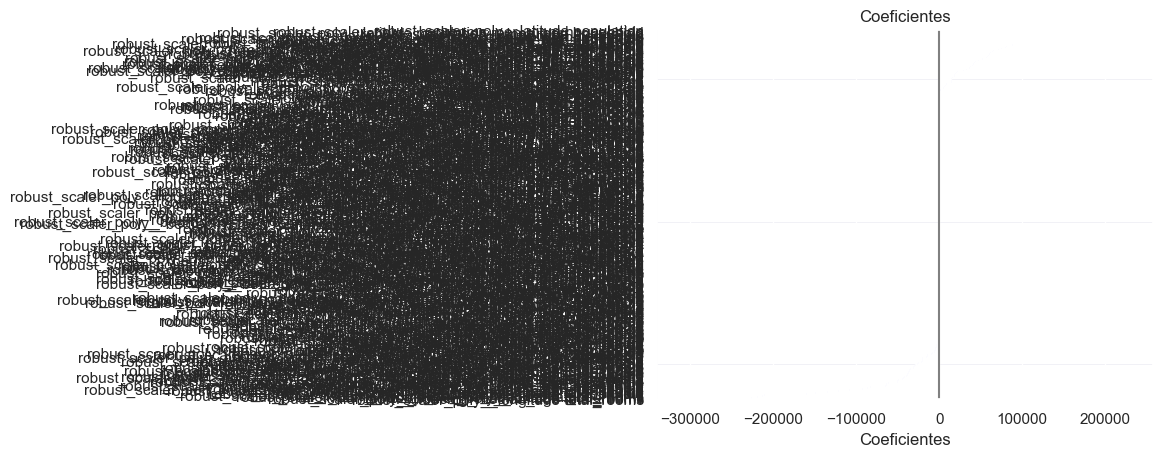

In [93]:
plot_coeficientes(coefs)

In [94]:
coefs[coefs["coeficiente"] == 0]

,coeficiente


In [95]:
# Coeficientes com valores muito altos ou muito baixos
coefs[coefs["coeficiente"].between(-100_000, 100_000)]

,coeficiente
robust_scaler_poly__households housing_median_age population_per_household,-93156.112775
robust_scaler_poly__population_per_household total_bedrooms,-86728.462596
robust_scaler_poly__latitude population_per_household,-83056.826523
robust_scaler_poly__households^2 population_per_household,-65851.996293
robust_scaler_poly__housing_median_age population rooms_per_household,-64778.441170
...,...
robust_scaler_poly__housing_median_age total_bedrooms,70662.564070
robust_scaler_poly__bedrooms_per_room rooms_per_household total_rooms,74928.369776
robust_scaler_poly__latitude rooms_per_household,79285.795021
robust_scaler_poly__rooms_per_household^2,80033.569447


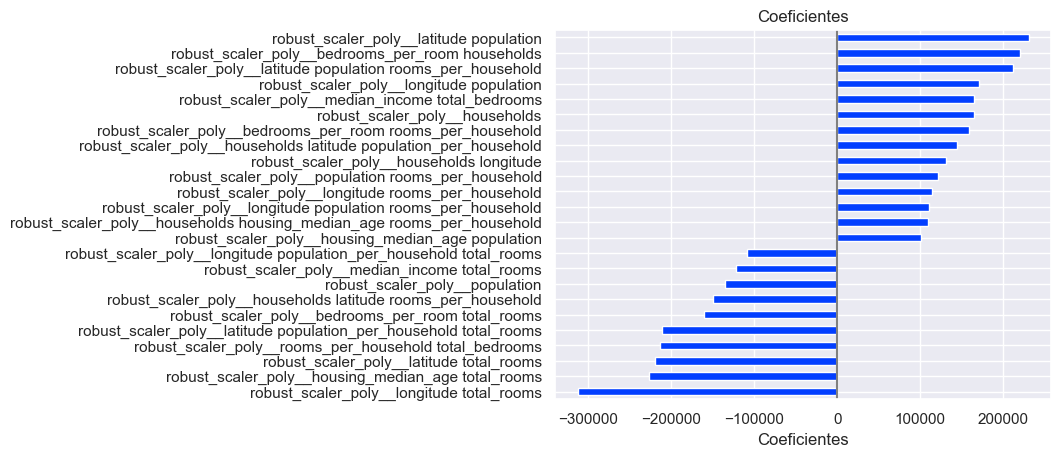

In [96]:
# Coeficientes que não estão entre -100_000 e 100_000
plot_coeficientes(coefs[~coefs["coeficiente"].between(-100_000, 100_000)])

Mesmo tendo maior score em relação ao processamento simples, o nível de complexidade aumentou

In [97]:
regressors = {
    # DummyRegressor
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    # LinearRegression sem target transformado
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    # LinearRegression com target transformado
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    # Melhor modelo
    "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [98]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.0061,0.003834,-0.000081,-77516.042766,-96239.705692,0.009935
1,DummyRegressor,0.002042,0.004578,-0.000146,-75787.787194,-95217.629397,0.00662
2,DummyRegressor,0.003507,0.002892,-0.001737,-76753.598961,-96253.253947,0.006398
3,DummyRegressor,0.002994,0.002531,-0.000101,-76837.804811,-95983.885799,0.005525
4,DummyRegressor,0.006065,0.006773,-0.000114,-76617.245449,-96182.764729,0.012838
5,LinearRegression,0.049609,0.014659,0.682162,-39855.690996,-54254.958188,0.064268
6,LinearRegression,0.038956,0.015636,0.66999,-40272.565467,-54695.230283,0.054592
7,LinearRegression,0.040237,0.013423,0.649247,-42178.05929,-56955.988706,0.053661
8,LinearRegression,0.031619,0.014286,0.669873,-40806.492497,-55146.318803,0.045905
9,LinearRegression,0.033688,0.010547,0.669023,-40788.496497,-55331.35106,0.044235


In [99]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004142,0.004122,-0.000436,-76702.495836,-95975.447913,0.008263
LinearRegression,0.038822,0.01371,0.668059,-40780.26095,-55276.769408,0.052532
LinearRegression_grid_search,0.380509,0.029246,0.715811,-35573.123622,-51140.053473,0.409756
LinearRegression_target,0.038362,0.01184,0.678009,-38676.262871,-54437.866279,0.050202


In [100]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004142,0.004122,-0.000436,-76702.495836,-95975.447913,0.008263
LinearRegression,0.038822,0.01371,0.668059,-40780.26095,-55276.769408,0.052532
LinearRegression_target,0.038362,0.01184,0.678009,-38676.262871,-54437.866279,0.050202
LinearRegression_grid_search,0.380509,0.029246,0.715811,-35573.123622,-51140.053473,0.409756


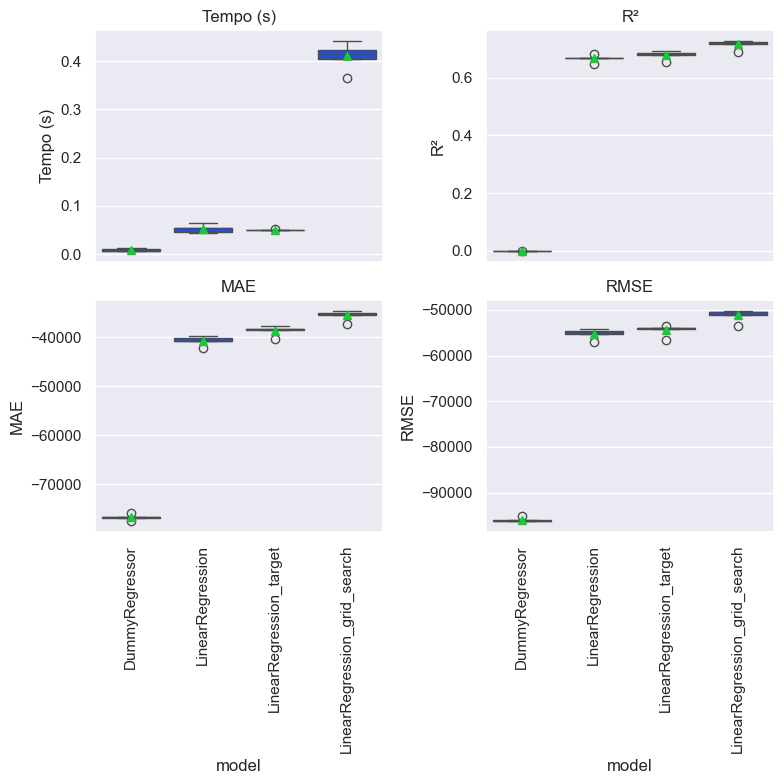

In [101]:
plot_comparar_metricas_modelos(df_resultados)

- Tempo: grid search (features polinomiais) está levando um tempo maior de 6x em relação ao LinearRegression
- R2, MAE, RMSE: grid search (features polinomiais) melhora um pouco as métricas que o LinearRegression
- É melhor usar o grid search (features polinomiais) que o LinearRegression

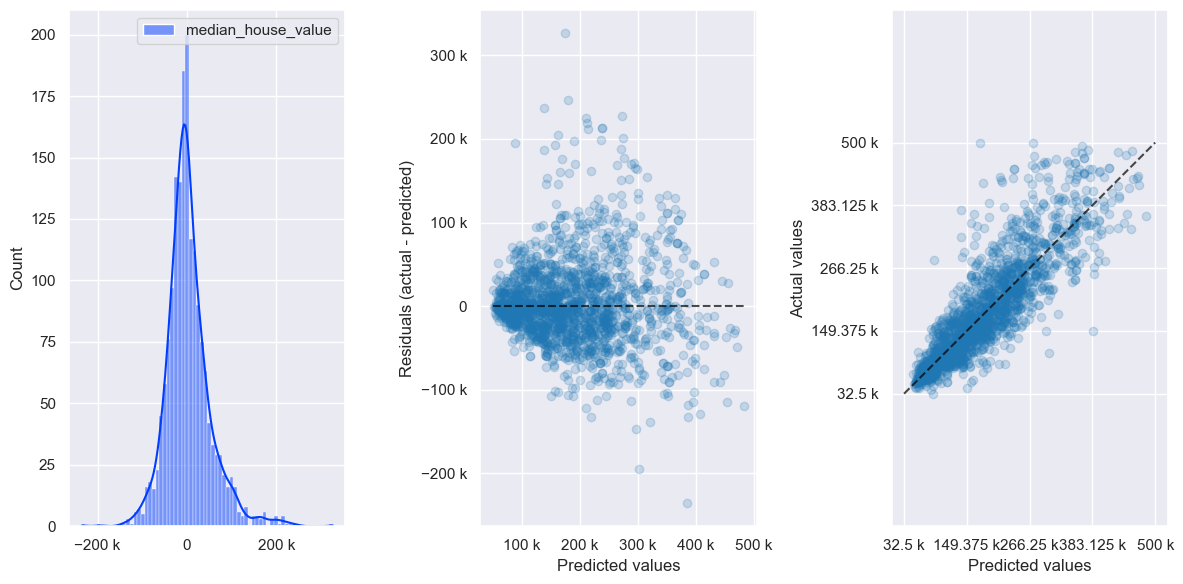

In [102]:
# Plota gráfico de resíduos com melhor modelo, usando 10% dos dados e com formatação de abreviação dos números
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

Pegando 10% dos dados e comparando os dados reais com os dados do melhor estimador de modelo (Features Polinomiais):
- Percebe-se que uma parte significativa dos pontos estão próximos da reta no gráfico de resíduos (2), fazendo que o modelo tenha menos erros
- Possue mais erros positivos que negativos, sendo observado tanto pelo histograma (1) com a cauda mais alongada para os valores positivos e o gráfico de dispersão de resíduos (2) com mais valores acima da reta que abaixo da reta